In [120]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import pandas as pd
import urllib.parse

# Read the TSV file
paths_finished_df = pd.read_csv('data/wikispeedia_paths-and-graph/paths_finished.tsv', 
                                sep='\t', 
                                comment='#', 
                                names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])

paths_finished_df['target'] = paths_finished_df['path'].apply(lambda x: urllib.parse.unquote(x.split(';')[-1]).replace('_', ' '))
paths_finished_df['is_finished'] = True

paths_unfinished_df = pd.read_csv('data/wikispeedia_paths-and-graph/paths_unfinished.tsv', 
                                sep='\t', 
                                comment='#', 
                                names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
paths_unfinished_df['is_finished'] = False
paths_unfinished_df['target'] = paths_unfinished_df['target'].apply(lambda x: urllib.parse.unquote(x).replace('_', ' '))

paths_df = pd.concat([paths_finished_df, paths_unfinished_df])



In [122]:
import urllib.parse

def find_backtracks(path):
    backtracks = []
    words = path.split(';')
    stack = []

    for word in words:
        if word == "<":
            if stack:
                backtracks.append(stack.pop())
        else:
            url_decoded = urllib.parse.unquote(word).replace('_', ' ')
            stack.append(url_decoded)

    return backtracks

paths_df['backtracks'] = paths_df['path'].apply(find_backtracks)

backtracks = pd.Series(paths_df['backtracks'].explode().dropna().tolist())
print(backtracks.value_counts())

United States       543
United Kingdom      352
England             333
Europe              252
Animal              229
                   ... 
Mauritania            1
Common Cuckoo         1
Citizen Kane          1
African Wild Dog      1
Riesling              1
Name: count, Length: 2911, dtype: int64


In [123]:

top_backtracks = backtracks.value_counts()
top_backtracks[top_backtracks >= 10]

United States        543
United Kingdom       352
England              333
Europe               252
Animal               229
                    ... 
Yeast                 10
Soil science          10
Biofuel               10
Drought               10
Liberal democracy     10
Name: count, Length: 849, dtype: int64

In [124]:
def path_to_list(path):
    return [urllib.parse.unquote(word).replace('_', ' ') for word in path.replace('<;', '').split(';')]

paths_df["traversed"] = paths_df["path"].apply(path_to_list)

paths_df.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,is_finished,type,backtracks,traversed
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African slave trade,True,NaN,[],"[14th century, 15th century, 16th century, Pac..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African slave trade,True,NaN,[],"[14th century, Europe, Africa, Atlantic slave ..."
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African slave trade,True,NaN,[],"[14th century, Niger, Nigeria, British Empire,..."
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,True,NaN,[],"[14th century, Renaissance, Ancient Greece, Gr..."
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John F. Kennedy,True,NaN,[],"[14th century, Italy, Roman Catholic Church, H..."


In [125]:
traversed = pd.Series(paths_df['traversed'].explode().dropna().tolist())

traversed.value_counts()

United States                 12449
Europe                         5611
United Kingdom                 5328
England                        4558
Earth                          4216
                              ...  
Steve Davis                       1
Tacitean studies                  1
Typhoon Ewiniar (2006)            1
Earwax                            1
Architecture of Windows NT        1
Name: count, Length: 4183, dtype: int64

                                                    backtracks  traversed  \
Local community                                            2.0          3   
Soil profile                                              29.0         47   
Wikipedia Text of the GNU Free Documentation Li...        61.0        122   
La Grande Armée                                            2.0          4   
Skåneland                                                  1.0          2   
Póvoa de Varzim                                            1.0          2   
Konrad Lorenz                                              4.0          9   
Shackleton (crater)                                        5.0         12   
Cape Canaveral                                            26.0         63   
Lighting designer                                         17.0         44   
Lens (anatomy)                                            23.0         60   
Income disparity                                           4.0         11   

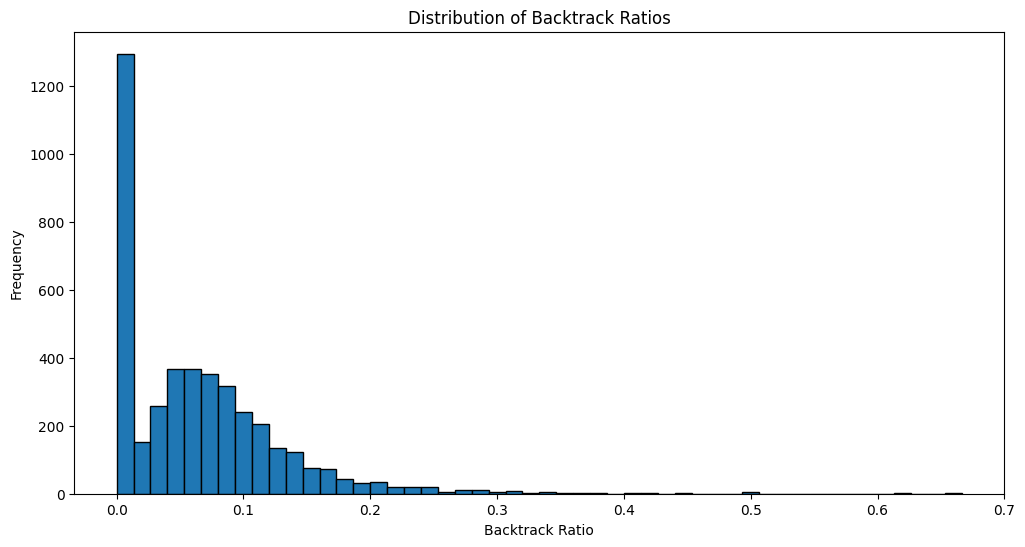

In [126]:
# Create a DataFrame with counts of backtracks and traversed
word_counts = pd.DataFrame({
    'backtracks': backtracks.value_counts(),
    'traversed': traversed.value_counts()
})

# Calculate the ratio of backtracks to traversed
word_counts['backtrack_ratio'] = word_counts['backtracks'] / word_counts['traversed']

# Fill NaN values with 0 (for words that were traversed but never backtracked)
word_counts['backtrack_ratio'] = word_counts['backtrack_ratio'].fillna(0)

# Sort by the ratio in descending order
word_counts_sorted = word_counts.sort_values('backtrack_ratio', ascending=False)

# Display the top 20 words with highest backtrack ratios for words with at least 100 occurrences
print(word_counts_sorted[word_counts_sorted['traversed'] >= 0].head(20))

# Optional: Plot the distribution of backtrack ratios
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(word_counts['backtrack_ratio'], bins=50, edgecolor='black')
plt.title('Distribution of Backtrack Ratios')
plt.xlabel('Backtrack Ratio')
plt.ylabel('Frequency')
plt.show()



In [127]:
# Calculate percentage of backtracks in finished vs unfinished paths
has_backtracks = paths_df['backtracks'].apply(len) > 0

# Get counts
finished_with_backtracks = (has_backtracks & paths_df['is_finished']).sum()
finished_total = paths_df['is_finished'].sum()

unfinished_with_backtracks = (has_backtracks & (~paths_df['is_finished'])).sum()
unfinished_total = (~paths_df['is_finished']).sum()

# Calculate percentages
finished_backtrack_pct = (finished_with_backtracks / finished_total) * 100
unfinished_backtrack_pct = (unfinished_with_backtracks / unfinished_total) * 100

print(f"Paths with backtracks:")
print(f"Finished paths: {finished_backtrack_pct:.1f}% ({finished_with_backtracks}/{finished_total})")
print(f"Unfinished paths: {unfinished_backtrack_pct:.1f}% ({unfinished_with_backtracks}/{unfinished_total})")


Paths with backtracks:
Finished paths: 17.5% (8995/51318)
Unfinished paths: 20.9% (5201/24875)


In [128]:
# Calculate average number of backtracks for finished vs unfinished paths
avg_backtracks_finished = paths_df[paths_df['is_finished']]['backtracks'].apply(len).mean()
avg_backtracks_unfinished = paths_df[~paths_df['is_finished']]['backtracks'].apply(len).mean()

print("\nAverage number of backtracks per game:")
print(f"Finished paths: {avg_backtracks_finished:.2f}")
print(f"Unfinished paths: {avg_backtracks_unfinished:.2f}")



Average number of backtracks per game:
Finished paths: 0.40
Unfinished paths: 0.52


In [129]:
# 
restarts = paths_unfinished_df[paths_unfinished_df["type"] == "restart" ]
immediate_restarts = restarts[restarts["path"].apply(lambda x: len(x.split(';'))) == 1]



In [130]:
# Get finished games with and without backtracks
finished_games = paths_df[paths_df['is_finished']]
finished_with_bt = finished_games[finished_games['backtracks'].apply(len) > 0]
finished_no_bt = finished_games[finished_games['backtracks'].apply(len) == 0]

# Calculate average duration for each group
avg_duration_with_bt = finished_with_bt['durationInSec'].median()
avg_duration_no_bt = finished_no_bt['durationInSec'].median()

print("\nMedian game duration for finished games:")
print(f"With backtracks: {avg_duration_with_bt:.1f} seconds")
print(f"Without backtracks: {avg_duration_no_bt:.1f} seconds")



Median game duration for finished games:
With backtracks: 194.0 seconds
Without backtracks: 94.0 seconds


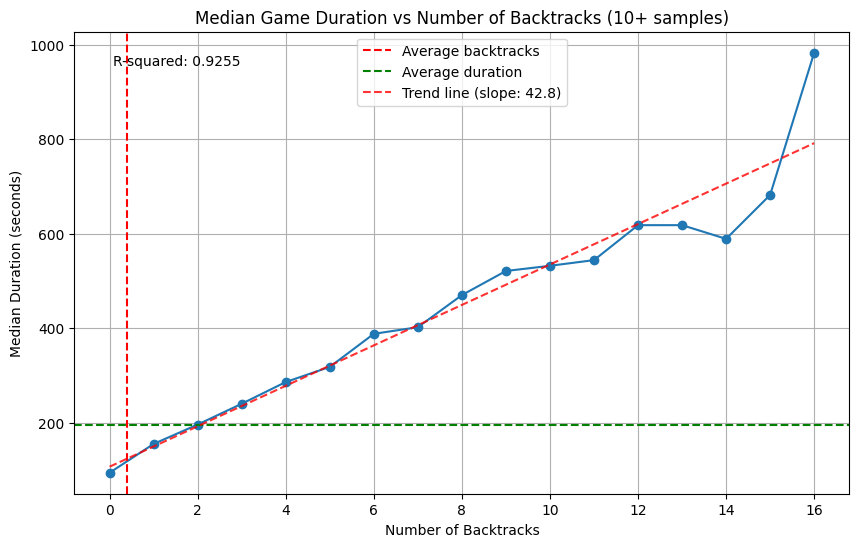

Counts of games with each number of backtracks:
backtracks
0     42323
1      5095
2      1726
3       815
4       411
5       268
6       173
7       138
8        89
9        71
10       39
11       29
12       24
13       26
14       10
15       13
16       11
dtype: int64

R-squared value: 0.9255


In [131]:
import numpy as np
from sklearn.metrics import r2_score

# Group finished games by number of backtracks and calculate median duration
backtrack_counts = finished_games.groupby(finished_games['backtracks'].apply(len)).size()
backtrack_durations = finished_games.groupby(finished_games['backtracks'].apply(len))['durationInSec'].median()

# Filter to keep only counts with at least 10 samples
filtered_counts = backtrack_counts[backtrack_counts >= 10]
filtered_durations = backtrack_durations[filtered_counts.index]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(filtered_durations.index, filtered_durations.values, marker='o')
plt.axvline(x=avg_backtracks_finished, color='r', linestyle='--', label='Average backtracks')
plt.axhline(y=avg_duration_with_bt, color='g', linestyle='--', label='Average duration')
plt.xlabel('Number of Backtracks')
plt.ylabel('Median Duration (seconds)')
plt.title('Median Game Duration vs Number of Backtracks (10+ samples)')
plt.grid(True)

# Add a trend line
z = np.polyfit(filtered_durations.index, filtered_durations.values, 1)
p = np.poly1d(z)
plt.plot(filtered_durations.index, p(filtered_durations.index), "r--", alpha=0.8, 
         label=f'Trend line (slope: {z[0]:.1f})')

# Calculate R-squared
r_squared = r2_score(filtered_durations.values, p(filtered_durations.index))

plt.legend()
plt.text(0.05, 0.95, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

print("Counts of games with each number of backtracks:")
print(filtered_counts)
print(f"\nR-squared value: {r_squared:.4f}")



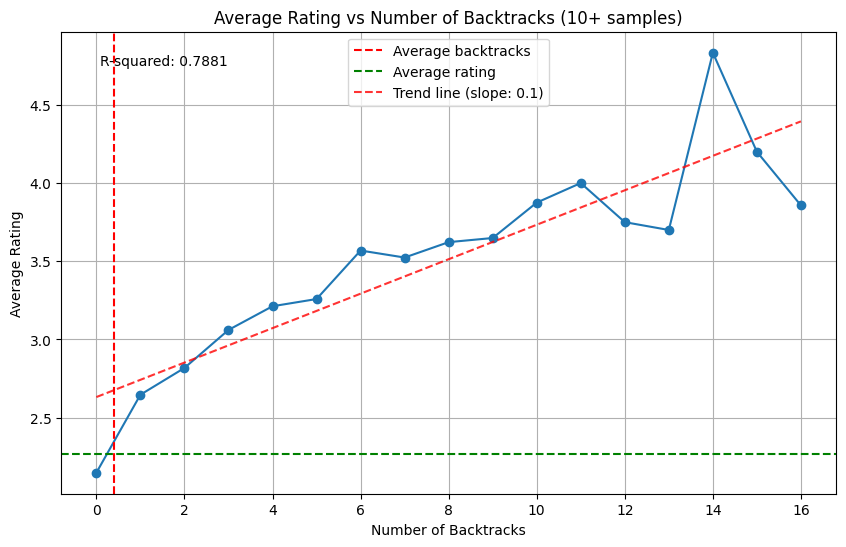

Counts of games with each number of backtracks:
backtracks
0     42323
1      5095
2      1726
3       815
4       411
5       268
6       173
7       138
8        89
9        71
10       39
11       29
12       24
13       26
14       10
15       13
16       11
dtype: int64

R-squared value: 0.7881


In [132]:
import numpy as np
from sklearn.metrics import r2_score

# Group finished games by number of backtracks and calculate median duration
backtrack_counts = finished_games.groupby(finished_games['backtracks'].apply(len)).size()
backtrack_ratings = finished_games.groupby(finished_games['backtracks'].apply(len))['rating'].mean()

# Filter to keep only counts with at least 10 samples
filtered_counts = backtrack_counts[backtrack_counts >= 10]
filtered_ratings = backtrack_ratings[filtered_counts.index]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(filtered_ratings.index, filtered_ratings.values, marker='o')
plt.xlabel('Number of Backtracks')
plt.ylabel('Average Rating')
plt.axvline(x=avg_backtracks_finished, color='r', linestyle='--', label='Average backtracks')
plt.axhline(y=finished_games['rating'].mean(), color='g', linestyle='--', label='Average rating')
plt.title('Average Rating vs Number of Backtracks (10+ samples)')
plt.grid(True)

# Add a trend line
z = np.polyfit(filtered_ratings.index, filtered_ratings.values, 1)
p = np.poly1d(z)

plt.plot(filtered_ratings.index, p(filtered_ratings.index), "r--", alpha=0.8, 
         label=f'Trend line (slope: {z[0]:.1f})')

# Calculate R-squared
r_squared = r2_score(filtered_ratings.values, p(filtered_ratings.index))

plt.legend()
plt.text(0.05, 0.95, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

print("Counts of games with each number of backtracks:")
print(filtered_counts)
print(f"\nR-squared value: {r_squared:.4f}")



In [133]:
# Was backtracking the right decision

In [134]:
# Category of the backtrack vs category of destination
# Category of the backtrack vs category of new page e.g. ....a;<;b... compare category of a and b

In [135]:
categories = pd.read_csv('data/wikispeedia_paths-and-graph/categories.tsv', sep='\t',comment='#', names=['page', 'category'])
categories['page'] = categories['page'].apply(lambda x: urllib.parse.unquote(x).replace('_', ' '))

categories.head()

,page,category
0,Áedán mac Gabráin,subject.History.British_History.British_Histor...
1,Áedán mac Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard Manet,subject.People.Artists


In [136]:
paths_df.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,is_finished,type,backtracks,traversed
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African slave trade,True,NaN,[],"[14th century, 15th century, 16th century, Pac..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African slave trade,True,NaN,[],"[14th century, Europe, Africa, Atlantic slave ..."
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African slave trade,True,NaN,[],"[14th century, Niger, Nigeria, British Empire,..."
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,True,NaN,[],"[14th century, Renaissance, Ancient Greece, Gr..."
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John F. Kennedy,True,NaN,[],"[14th century, Italy, Roman Catholic Church, H..."


In [137]:


# Get all backtrack targets
backtrack_targets = paths_df[paths_df['backtracks'].apply(len) > 0][['backtracks','target']]
print(backtrack_targets.head())
# Create a list to store individual backtrack entries
backtrack_entries = []

# Iterate through each row that has backtracks
for _, row in backtrack_targets.iterrows():
    # For each backtrack in the row
    for backtrack in row['backtracks']:
        # Add an entry with the backtrack and target
        backtrack_entries.append({
            'backtrack': backtrack,
            'target': row['target']
        })

# Convert to DataFrame
backtrack_df = pd.DataFrame(backtrack_entries)

print("\nArticle of backtrack vs target")
print(backtrack_df.value_counts().head(20))


                                           backtracks   target
10                                         [Sunlight]  Rainbow
13     [Sunlight, Rain, Earth's atmosphere, Sunlight]  Rainbow
14                                      [Cloud, Rain]  Rainbow
16  [Republic of Ireland, Europe, Europe, Republic...  Rainbow
19         [Physics, Ultraviolet, Earth's atmosphere]  Rainbow

Article of backtrack vs target
backtrack         target     
Soybean           Bean           111
Herbivore         Zebra           89
Protein           Bean            62
Cell (biology)    Telephone       46
Sport             Tiger Woods     42
Salsa music       Bean            42
Coffee            Bean            38
Optical fiber     Telephone       37
Animal            Zebra           34
Mexico            Bean            34
Sound             Telephone       31
Internet          Telephone       30
Plant             Bean            30
Eye               Telephone       30
Computer science  Telephone       28
Food 

In [138]:
#target with most backtracks
backtrack_df['target'].value_counts().head(20)


target
Bean                      805
Telephone                 722
Zebra                     690
Viking                    595
Tiger Woods               274
Fugu                      199
Nurse sharks              156
Vole                      151
Three Laws of Robotics    134
Apple                     123
Google                    121
Wood                      111
Soil moisture              92
The X-Files                89
Monkey                     87
Yes Minister               84
Giant Panda                82
IPod                       82
Indian Peafowl             81
Dog                        79
Name: count, dtype: int64

In [139]:
#targets with the highest average backtracks
paths_df['backtrack_length'] = paths_df['backtracks'].apply(len)
# Get target counts
target_counts = paths_df['target'].value_counts()
# Filter for targets with >10 paths and calculate mean backtrack length
paths_df[paths_df['target'].isin(target_counts[target_counts > 10].index)]\
    .groupby('target')['backtrack_length'].median()\
    .sort_values(ascending=False)\
    .head(20)



target
Papal conclave              1.5
British Virgin Islands      1.5
Stargate SG-1               1.0
Coriander                   1.0
North Sea oil               1.0
Dik-dik                     1.0
African Buffalo             1.0
Great Salt Lake             1.0
Metallurgy                  1.0
Soil moisture               1.0
Walt Disney                 1.0
Onion                       1.0
Spacecraft propulsion       1.0
Community                   1.0
Crab Nebula                 1.0
List of rivers by length    1.0
Geography of Ireland        1.0
Set                         1.0
Queen (band)                1.0
Pikachu                     1.0
Name: backtrack_length, dtype: float64

In [140]:
paths_df[paths_df['target'].isin(target_counts[target_counts > 30].index)]\
    .groupby('target')['backtrack_length'].mean()\
    .sort_values(ascending=True)\
    .head(20)

target
Kuwait City               0.000000
Isaac Newton              0.000000
George Washington         0.000000
Flower                    0.000000
Iraq                      0.022222
Republic of China         0.023810
Electron                  0.024390
Mexico                    0.026316
Earth                     0.026316
Indonesia                 0.032258
Christianity              0.035088
London                    0.037736
England                   0.040000
Ancient Greece            0.048780
Oregon                    0.050000
United States Congress    0.054054
Baghdad                   0.054054
Abraham Lincoln           0.054054
Aristotle                 0.055556
Great Lakes               0.055556
Name: backtrack_length, dtype: float64

In [141]:
# longueur de la page? nombre de lien sortant? 
# was backtrack a good idea? Distance de la target avant/apres backtracks

In [142]:
articles_df = pd.read_csv('data/wikispeedia_paths-and-graph/articles.tsv', sep='\t', comment='#', names=['page'])
articles_df['page'] = articles_df['page'].apply(lambda x: urllib.parse.unquote(x).replace('_', ' '))

articles_df.head()

,page
0,Áedán mac Gabráin
1,Åland
2,Édouard Manet
3,Éire
4,Óengus I of the Picts


In [143]:
for traversed in paths_df['traversed'].head(10):
    print(traversed)



['14th century', '15th century', '16th century', 'Pacific Ocean', 'Atlantic Ocean', 'Accra', 'Africa', 'Atlantic slave trade', 'African slave trade']
['14th century', 'Europe', 'Africa', 'Atlantic slave trade', 'African slave trade']
['14th century', 'Niger', 'Nigeria', 'British Empire', 'Slavery', 'Africa', 'Atlantic slave trade', 'African slave trade']
['14th century', 'Renaissance', 'Ancient Greece', 'Greece']
['14th century', 'Italy', 'Roman Catholic Church', 'HIV', 'Ronald Reagan', 'President of the United States', 'John F. Kennedy']
['14th century', 'Europe', 'North America', 'United States', 'President of the United States', 'John F. Kennedy']
['14th century', 'China', 'Gunpowder', 'Fire']
['14th century', 'Time', 'Isaac Newton', 'Light', 'Color', 'Rainbow']
['14th century', 'Time', 'Light', 'Rainbow']
['14th century', '15th century', 'Plato', 'Nature', 'Ultraviolet', 'Color', 'Rainbow']


In [144]:
import numpy as np

def load_distance_matrix(filepath):

    # Read the file and create matrix
    matrix = []
    with open(filepath, 'r') as file:
        for line in file:
            # Skip comment lines and empty lines
            if line.startswith('#') or not line.strip():
                continue
            # Convert each character to integer, ignoring underscores
            row = [int(char.replace('_', '-1')) for char in line.strip()]
            matrix.append(row)
    
    return np.array(matrix)

filepath = "data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt"
distance_matrix = load_distance_matrix(filepath)
print(distance_matrix.shape)



(4604, 4604)


In [145]:
from distance import get_distance

print(get_distance("Áedán mac Gabráin", "Zulu"))



2


In [146]:
backtrack_info = []
j=0

def find_backtracks_info(row):
    backtracks = []
    words = row['path'].split(';')
    stack = []
    backtrack_from = None
    global j
    j+=1
    if j%1000==0:
            print(f"Processed {j} paths")
    position=0
    
    for i, word in enumerate(words):
        
        
        if word == "<":
            if stack and backtrack_from is None:
                backtrack_from = stack.pop()
                
        else:
            
            if backtrack_from is not None:
                distance_before_backtrack = get_distance(backtrack_from, row['target'])
                distance_after_backtrack = get_distance(urllib.parse.unquote(word).replace('_', ' '), row['target'])
                if distance_before_backtrack is not pd.NA and distance_after_backtrack is not pd.NA:
                    backtracks.append({
                        'before': backtrack_from,
                        'after': urllib.parse.unquote(word).replace('_', ' '),
                        'position_backtrack': position,
                        'distance_before': distance_before_backtrack,
                        'distance_after': distance_after_backtrack,
                        'gain': distance_before_backtrack - distance_after_backtrack,
                        'target': row['target']
                    })
                backtrack_from = None
            url_decoded = urllib.parse.unquote(word).replace('_', ' ')
            stack.append(url_decoded)
            position+=1

    return backtracks

print(paths_df[paths_df['backtracks'].apply(len) > 0][['path', 'target']].shape)
l = []
for i, row in paths_df[paths_df['backtracks'].apply(len) > 0][['path', 'target']].iterrows():
    l.append(find_backtracks_info(row))

backtrack_before_after = pd.DataFrame([item for sublist in l for item in sublist])



(14196, 2)
Processed 1000 paths
Processed 2000 paths
Processed 3000 paths
Processed 4000 paths
Processed 5000 paths
Processed 6000 paths
Processed 7000 paths
Processed 8000 paths
Processed 9000 paths
Processed 10000 paths
Article not found: Macedonia
Article not found: Republic of Macedonia or Macedonia
Article not found: Macedonia
Article not found: Alexander the Great or Macedonia
Processed 11000 paths
Processed 12000 paths
Article not found: Christmas
Article not found: Earth or Christmas
Article not found: Christmas
Article not found: Glacier or Christmas
Article not found: Bogota
Article not found: Bogotá or Bogota
Article not found: Bogota
Article not found: Bogotá or Bogota
Processed 13000 paths
Processed 14000 paths
Article not found: Christmas
Article not found: Sunlight or Christmas
Article not found: Christmas
Article not found: Solar eclipse or Christmas
Article not found: Christmas
Article not found: Agriculture or Christmas
Article not found: Christmas
Article not found: 

In [147]:
backtrack_before_after.head(10)

,before,after,position_backtrack,distance_before,distance_after,gain,target
0,Sunlight,Sun,6,3,2,1,Rainbow
1,Sunlight,Rain,6,3,2,1,Rainbow
2,Rain,Sunlight,7,2,3,-1,Rainbow
3,Earth's atmosphere,Sun,9,3,2,1,Rainbow
4,Cloud,Rainbow,6,2,0,2,Rainbow
5,Republic of Ireland,Europe,3,3,3,0,Rainbow
6,Europe,Europe,4,3,3,0,Rainbow
7,Republic of Ireland,Time,6,3,2,1,Rainbow
8,Physics,Day,3,2,3,-1,Rainbow
9,Ultraviolet,Earth's atmosphere,7,2,3,-1,Rainbow


In [148]:
print(f'Average gain: {backtrack_before_after["gain"].mean():.2f}')





Average gain: 0.30


In [149]:
print(f"Average position of backtrack: {backtrack_before_after['position_backtrack'].mean():.2f}")


Average position of backtrack: 6.96


position_backtrack
2     0.220278
3     0.273567
4     0.304334
5     0.366726
6     0.358606
7     0.380867
8     0.315476
9     0.325626
10    0.268041
11    0.323283
12    0.231818
13    0.251397
14    0.391892
15    0.345992
16    0.308140
17    0.262069
18    0.275862
19    0.091667
Name: gain, dtype: float64


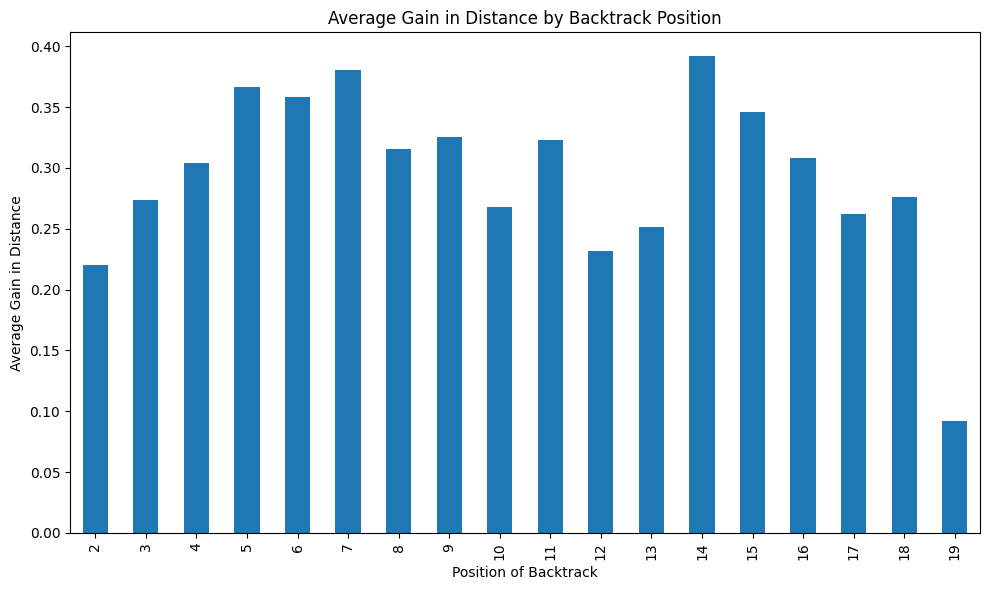

In [150]:
position_counts = backtrack_before_after['position_backtrack'].value_counts()
valid_positions = position_counts[position_counts > 100].index
print(backtrack_before_after[backtrack_before_after['position_backtrack'].isin(valid_positions)]
      .groupby('position_backtrack')["gain"].mean())
      
# Plot the average gain by position
plt.figure(figsize=(10,6))
position_gain = backtrack_before_after[backtrack_before_after['position_backtrack'].isin(valid_positions)].groupby('position_backtrack')["gain"].mean()
position_gain.plot(kind='bar')
plt.title('Average Gain in Distance by Backtrack Position')
plt.errorbar(x=range(len(position_gain)), y=position_gain.values,
            fmt='none', color='black', capsize=5)
plt.xlabel('Position of Backtrack') 
plt.ylabel('Average Gain in Distance')
plt.tight_layout()
plt.show()


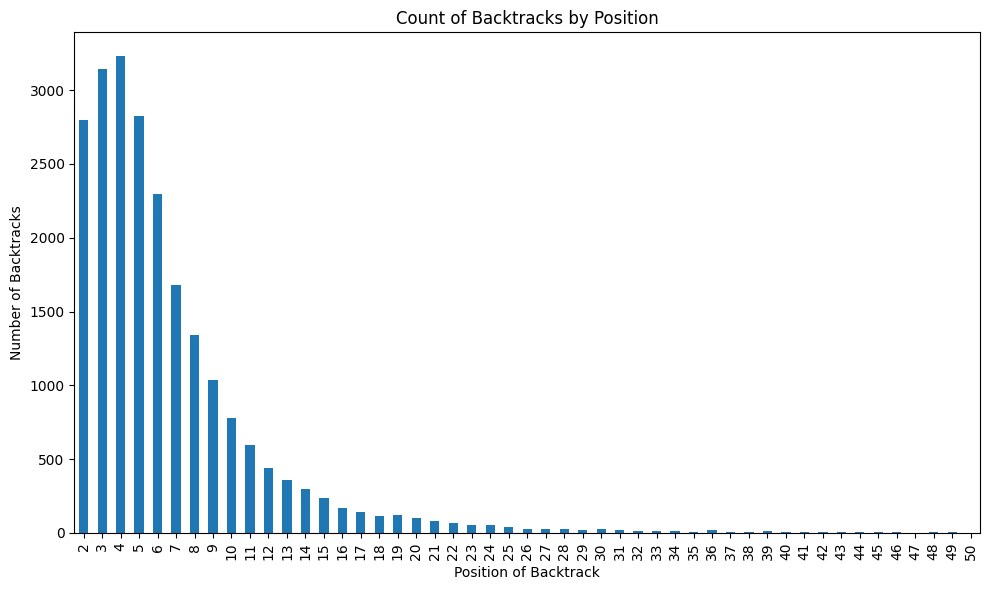

In [151]:
# Plot the count of backtracks at each position
plt.figure(figsize=(10,6))
position_counts = backtrack_before_after['position_backtrack'].value_counts()
position_counts[position_counts.index <= 50].sort_index().plot(kind='bar')
plt.title('Count of Backtracks by Position')
plt.xlabel('Position of Backtrack')
plt.ylabel('Number of Backtracks') 
plt.tight_layout()
plt.show()


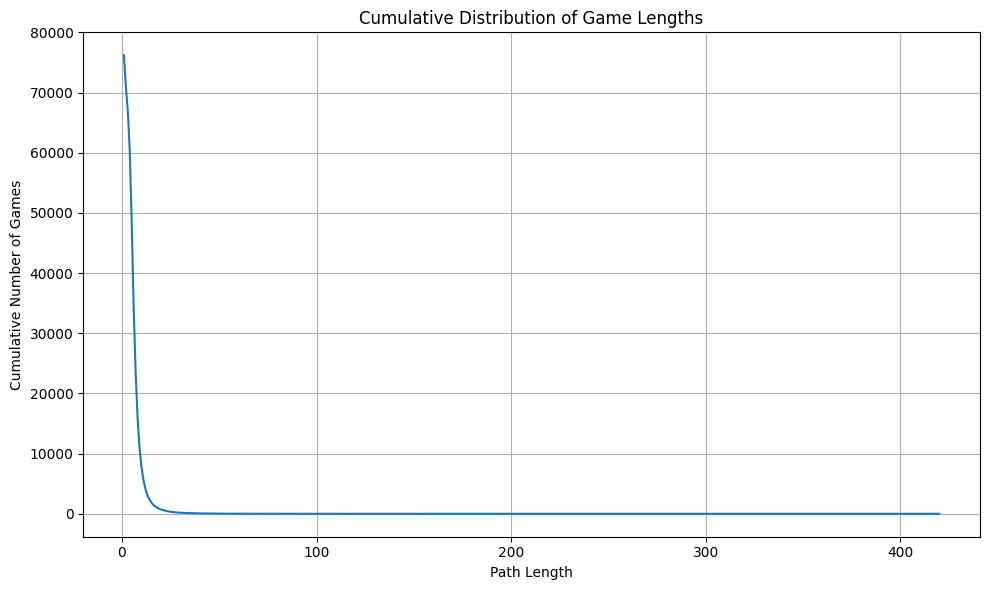


Path length statistics:
Mean path length: 5.8
Median path length: 5.0
Min path length: 1
Max path length: 420


In [152]:
# Calculate path lengths and their cumulative counts
path_lengths = paths_df['traversed'].str.len()
length_counts = path_lengths.value_counts().sort_index()
inverse_cumulative_counts = length_counts.iloc[::-1].cumsum()

# Plot cumulative distribution
plt.figure(figsize=(10,6))
plt.plot(inverse_cumulative_counts.index, inverse_cumulative_counts.values)
plt.title('Cumulative Distribution of Game Lengths')
plt.xlabel('Path Length')
plt.ylabel('Cumulative Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some statistics
print("\nPath length statistics:")
print(f"Mean path length: {path_lengths.mean():.1f}")
print(f"Median path length: {path_lengths.median():.1f}")
print(f"Min path length: {path_lengths.min()}")
print(f"Max path length: {path_lengths.max()}")


traversed
420        1
192        2
114        3
103        4
91         5
       ...  
5      48532
4      60227
3      66947
2      70968
1      76193
Name: count, Length: 71, dtype: int64
position_backtrack
4      3230
3      3140
5      2825
2      2801
6      2295
       ... 
121       1
123       1
414       1
127       1
87        1
Name: count, Length: 104, dtype: int64


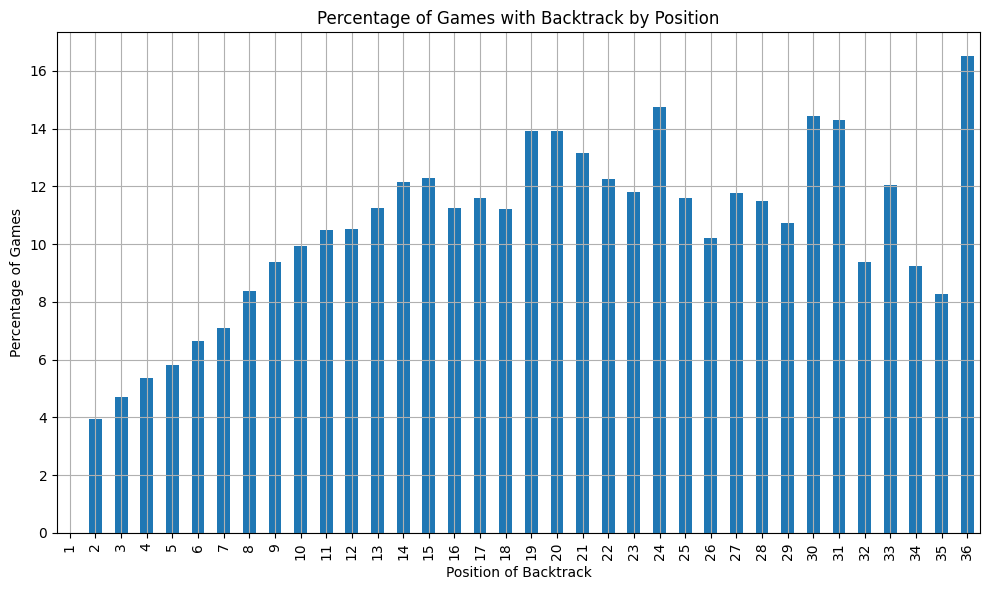


Backtrack percentage statistics:
Maximum percentage: 23.1% at position 66
Mean percentage across positions: 10.5%


In [153]:

# Calculate percentage of games that had a backtrack at each position
print(inverse_cumulative_counts)

print(backtrack_before_after['position_backtrack'].value_counts())
backtrack_percentages = (backtrack_before_after['position_backtrack'].value_counts() / inverse_cumulative_counts * 100)

# Plot percentages for indexes with at least 100 paths
plt.figure(figsize=(10,6))
backtrack_percentages[backtrack_percentages.index <= 36].sort_index().plot(kind='bar')
plt.title('Percentage of Games with Backtrack by Position')
plt.xlabel('Position of Backtrack')
plt.ylabel('Percentage of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some statistics
print("\nBacktrack percentage statistics:")
print(f"Maximum percentage: {backtrack_percentages.max():.1f}% at position {backtrack_percentages.idxmax()}")
print(f"Mean percentage across positions: {backtrack_percentages.mean():.1f}%")
